### Imports

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import itertools
from torchsummary import summary

%matplotlib inline

### Functions

In [2]:
def classes_counter(dataset,mode=0):
    if mode==0:
        K = len(set(dataset.targets.numpy()))
    elif mode==1:
        K = len(set(dataset.targets))
        
    return K

def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader


def create_model_and_train(K,train_dataset,test_dataset,model_mode="CNN",batch_size=128,n_epochs=100,new=True):
    if model_mode=="CNN":
        if new:
            model=CNN2(K)
        else:
            model = CNN(K)
    elif model_mode=="Linear":
        model = nn.Sequential(
            nn.Linear(3072,4096),
            nn.ReLU(),
            nn.Linear(4096,8192),
            nn.ReLU(),
            nn.Linear(8192,8192),
            nn.ReLU(),
            nn.Linear(8192,4096),
            nn.ReLU(),
            nn.Linear(4096,2048),
            nn.ReLU(),
            nn.Linear(2048,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128,10),
            )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=batch_size)
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,3072)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,3072)
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return model,train_losses, test_losses, device, train_loader, test_loader

def tmp_loader_show(train_dataset):
    tmp_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=1,shuffle=True)
    for x,y in tmp_loader:
        print(x)
        print(x.shape)
        break
        
        
def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def acc_compouter(model,device,data_loader,model_mode="CNN"):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,3072)

        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc

def predict_model(model,data_loader,dataset,device,model_mode="CNN",mode=0):
    if mode==0:
        x = dataset.data.numpy()
        y = dataset.targets.numpy()
    elif mode==1:
        x = dataset.data
        y = dataset.targets
    
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,3072)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Data Augmentation

In [3]:
# https://pytorch.org/vision/stable/transforms.html

In [4]:
def dataset_creator(mode,augment=False):
    if mode=="train":
        if augment:
            transformer_train = torchvision.transforms.Compose([
#                 transforms.ColorJitter(brightness=0.2,contrast=0.2,saturation=0.2,hue=0.2),
                transforms.RandomCrop(32,padding=4),
                transforms.RandomHorizontalFlip(p=0.5),
#                 transforms.RandomRotation(degree=15),
                transforms.RandomAffine(0, translate=(0.1,0.1)),
#                 transforms.RandomPerspective(),
                transforms.ToTensor(),
            ])
            train_dataset = torchvision.datasets.CIFAR10(root=".",train=True,transform = transformer_train,download=True)

        else:
            train_dataset = torchvision.datasets.CIFAR10(root=".",train=True,transform = transforms.ToTensor(),download=True)
            
        return train_dataset
    else:
        test_dataset  = torchvision.datasets.CIFAR10(root=".",train=False,transform=transforms.ToTensor(),download=True)

        return test_dataset


### Load Data

In [13]:
train_dataset_augment =  dataset_creator(mode="train",augment=True)
train_dataset =  dataset_creator(mode="train",augment=False)

test_dataset =  dataset_creator(mode="test")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [14]:
train_dataset.data

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [15]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [16]:
train_dataset.targets

[6,
 9,
 9,
 4,
 1,
 1,
 2,
 7,
 8,
 3,
 4,
 7,
 7,
 2,
 9,
 9,
 9,
 3,
 2,
 6,
 4,
 3,
 6,
 6,
 2,
 6,
 3,
 5,
 4,
 0,
 0,
 9,
 1,
 3,
 4,
 0,
 3,
 7,
 3,
 3,
 5,
 2,
 2,
 7,
 1,
 1,
 1,
 2,
 2,
 0,
 9,
 5,
 7,
 9,
 2,
 2,
 5,
 2,
 4,
 3,
 1,
 1,
 8,
 2,
 1,
 1,
 4,
 9,
 7,
 8,
 5,
 9,
 6,
 7,
 3,
 1,
 9,
 0,
 3,
 1,
 3,
 5,
 4,
 5,
 7,
 7,
 4,
 7,
 9,
 4,
 2,
 3,
 8,
 0,
 1,
 6,
 1,
 1,
 4,
 1,
 8,
 3,
 9,
 6,
 6,
 1,
 8,
 5,
 2,
 9,
 9,
 8,
 1,
 7,
 7,
 0,
 0,
 6,
 9,
 1,
 2,
 2,
 9,
 2,
 6,
 6,
 1,
 9,
 5,
 0,
 4,
 7,
 6,
 7,
 1,
 8,
 1,
 1,
 2,
 8,
 1,
 3,
 3,
 6,
 2,
 4,
 9,
 9,
 5,
 4,
 3,
 6,
 7,
 4,
 6,
 8,
 5,
 5,
 4,
 3,
 1,
 8,
 4,
 7,
 6,
 0,
 9,
 5,
 1,
 3,
 8,
 2,
 7,
 5,
 3,
 4,
 1,
 5,
 7,
 0,
 4,
 7,
 5,
 5,
 1,
 0,
 9,
 6,
 9,
 0,
 8,
 7,
 8,
 8,
 2,
 5,
 2,
 3,
 5,
 0,
 6,
 1,
 9,
 3,
 6,
 9,
 1,
 3,
 9,
 6,
 6,
 7,
 1,
 0,
 9,
 5,
 8,
 5,
 2,
 9,
 0,
 8,
 8,
 0,
 6,
 9,
 1,
 1,
 6,
 3,
 7,
 6,
 6,
 0,
 6,
 6,
 1,
 7,
 1,
 5,
 8,
 3,
 6,
 6,
 8,
 6,
 8,
 4,
 6,
 6,


In [17]:
K = classes_counter(train_dataset,1)
print(K)

10


In [18]:
tmp_loader_show(train_dataset)

# look at the shape (N,C,H,W)

tensor([[[[0.3255, 0.2941, 0.2196,  ..., 0.2784, 0.2549, 0.2314],
          [0.4824, 0.3725, 0.3412,  ..., 0.2627, 0.2392, 0.2353],
          [0.5137, 0.2549, 0.3333,  ..., 0.2275, 0.2549, 0.3098],
          ...,
          [0.6000, 0.5725, 0.5647,  ..., 0.3961, 0.4588, 0.5059],
          [0.5882, 0.5765, 0.5843,  ..., 0.6000, 0.6078, 0.6235],
          [0.5843, 0.5961, 0.6000,  ..., 0.5961, 0.5882, 0.5961]],

         [[0.3412, 0.3098, 0.2353,  ..., 0.3137, 0.2941, 0.2667],
          [0.4863, 0.3725, 0.3412,  ..., 0.2941, 0.2784, 0.2706],
          [0.5412, 0.2745, 0.3490,  ..., 0.2588, 0.2902, 0.3451],
          ...,
          [0.6235, 0.6000, 0.5922,  ..., 0.4314, 0.4902, 0.5373],
          [0.6078, 0.5882, 0.5882,  ..., 0.6314, 0.6392, 0.6549],
          [0.6118, 0.6039, 0.6000,  ..., 0.6275, 0.6196, 0.6275]],

         [[0.2941, 0.2706, 0.2000,  ..., 0.2157, 0.1686, 0.1451],
          [0.4078, 0.3176, 0.3098,  ..., 0.2000, 0.1569, 0.1529],
          [0.4627, 0.2275, 0.3255,  ..., 0

### Create model

In [19]:
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        
        self.fc1 = nn.Linear(128*3*3, 1024)
        self.fc2 = nn.Linear(1024,K)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = x.view(-1,128*3*3)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        
        return x

# H_out = H_in + 2p - 2 ---- p:padding
class CNN2(nn.Module):
    def __init__(self,K):
        super(CNN2,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
        )
        
        self.fc1 = nn.Linear(128*4*4, 1024)
        self.fc2 = nn.Linear(1024,K)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.dropout(x, p=0.5)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.2)
        x = self.fc2(x)
        return x

### 1.CNN - simple

In [20]:
model_CNN, train_losses_CNN, test_losses_CNN, device ,train_loader, test_loader = create_model_and_train(K,train_dataset,test_dataset,model_mode="CNN",batch_size=128,n_epochs=30,new=False)

cuda:0
Epoch 1/30, Train Loss: 1.6947, Test Loss: 1.4772, Duration: 0:00:15.710580
Epoch 2/30, Train Loss: 1.4127, Test Loss: 1.3496, Duration: 0:00:14.481921
Epoch 3/30, Train Loss: 1.3098, Test Loss: 1.2917, Duration: 0:00:24.653582
Epoch 4/30, Train Loss: 1.2253, Test Loss: 1.2217, Duration: 0:00:19.908308
Epoch 5/30, Train Loss: 1.1650, Test Loss: 1.2009, Duration: 0:00:16.618301
Epoch 6/30, Train Loss: 1.1009, Test Loss: 1.1562, Duration: 0:00:16.776068
Epoch 7/30, Train Loss: 1.0527, Test Loss: 1.1322, Duration: 0:00:18.595226
Epoch 8/30, Train Loss: 1.0067, Test Loss: 1.1111, Duration: 0:00:18.176578
Epoch 9/30, Train Loss: 0.9628, Test Loss: 1.1054, Duration: 0:00:23.271666
Epoch 10/30, Train Loss: 0.9327, Test Loss: 1.0884, Duration: 0:00:15.075742
Epoch 11/30, Train Loss: 0.8951, Test Loss: 1.0630, Duration: 0:00:14.865462
Epoch 12/30, Train Loss: 0.8613, Test Loss: 1.0491, Duration: 0:00:14.801796
Epoch 13/30, Train Loss: 0.8360, Test Loss: 1.0383, Duration: 0:00:21.764526
E

#### Evaluate model and plot results

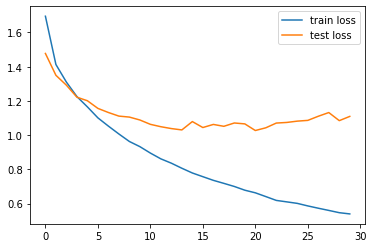

In [21]:
plot_test_and_train_metric(train_losses_CNN, test_losses_CNN,"loss")

In [22]:
train_acc_CNN = acc_compouter(model_CNN,device,train_loader,model_mode="CNN")
print(f"train acc: {train_acc_CNN}")

test_acc_CNN = acc_compouter(model_CNN,device,test_loader,model_mode="CNN")
print(f"test acc: {test_acc_CNN}")

train acc: 0.8216
test acc: 0.6601


Confusion matrix, without normalization
[[687  21  63  32  19  10   9  18  94  47]
 [ 21 757  12   8   1   2  10   6  43 140]
 [ 68   8 540  81  95  64  73  42  19  10]
 [ 16   9  82 510  65 176  66  33  19  24]
 [ 27   3  89  82 597  43  61  75  15   8]
 [  7  10  68 248  60 506  28  51   7  15]
 [  8   8  42  83  52  29 752  10   7   9]
 [ 18   5  39  45  79  76   4 703   2  29]
 [ 68  37  19  18  17   5   4   4 796  32]
 [ 39  76  15  20  11  12  14  26  27 760]]


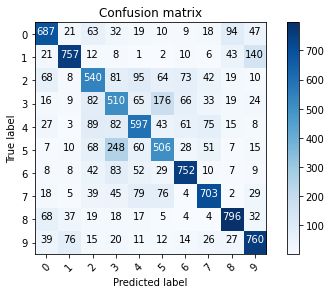

In [23]:
p_test_CNN,y_test,x_test = predict_model(model_CNN,test_loader,test_dataset,device,model_mode="CNN",mode=1)

cm_CNN = confusion_matrix(y_test,p_test_CNN)
plot_confusion_matrix(cm_CNN, list(range(K)))

In [24]:
cifar_labels = '''airplane
automobile
bird
car
deer
dog
frog
horse
ship
truck
'''.split("\n")

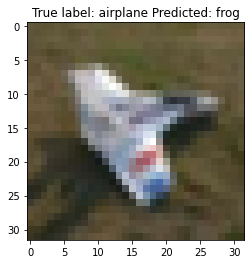

In [25]:
p_test_CNN = p_test_CNN.astype(np.uint8)
misclassified_idx = np.where(p_test_CNN!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (cifar_labels[y_test[i]], cifar_labels[int(p_test_CNN[i])]));

In [32]:
# model summary
summary(model_CNN, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             896
            Conv2d-2             [-1, 64, 7, 7]          18,496
            Conv2d-3            [-1, 128, 3, 3]          73,856
            Linear-4                 [-1, 1024]       1,180,672
            Linear-5                   [-1, 10]          10,250
Total params: 1,284,170
Trainable params: 1,284,170
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.10
Params size (MB): 4.90
Estimated Total Size (MB): 5.01
----------------------------------------------------------------


### 2.CNN - improved

In [26]:
model_CNN_improved, train_losses_CNN_improved, test_losses_CNN_improved, device ,train_loader_improved, test_loader_improved = create_model_and_train(K,train_dataset_augment,test_dataset,model_mode="CNN",batch_size=128,n_epochs=80,new=True)

cuda:0
Epoch 1/80, Train Loss: 1.4162, Test Loss: 1.0806, Duration: 0:00:45.292014
Epoch 2/80, Train Loss: 1.0017, Test Loss: 0.8964, Duration: 0:00:44.979675
Epoch 3/80, Train Loss: 0.8465, Test Loss: 0.7853, Duration: 0:00:45.153418
Epoch 4/80, Train Loss: 0.7571, Test Loss: 0.6994, Duration: 0:00:45.170517
Epoch 5/80, Train Loss: 0.6891, Test Loss: 0.6706, Duration: 0:00:45.205211
Epoch 6/80, Train Loss: 0.6476, Test Loss: 0.6352, Duration: 0:00:45.162837
Epoch 7/80, Train Loss: 0.6104, Test Loss: 0.6234, Duration: 0:00:45.086117
Epoch 8/80, Train Loss: 0.5787, Test Loss: 0.5726, Duration: 0:00:44.970726
Epoch 9/80, Train Loss: 0.5511, Test Loss: 0.5721, Duration: 0:00:44.897201
Epoch 10/80, Train Loss: 0.5301, Test Loss: 0.5504, Duration: 0:00:44.983349
Epoch 11/80, Train Loss: 0.5048, Test Loss: 0.5572, Duration: 0:00:45.013993
Epoch 12/80, Train Loss: 0.4941, Test Loss: 0.5204, Duration: 0:00:45.026032
Epoch 13/80, Train Loss: 0.4800, Test Loss: 0.5413, Duration: 0:00:44.718728
E

#### Evaluate model and plot results

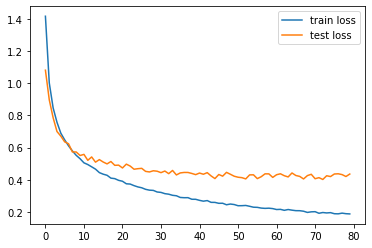

In [27]:
plot_test_and_train_metric(train_losses_CNN_improved, test_losses_CNN_improved,"loss")

In [28]:
train_acc_CNN_improved = acc_compouter(model_CNN_improved,device,train_loader_improved,model_mode="CNN")
print(f"train acc: {train_acc_CNN_improved}")

test_acc_CNN_improved = acc_compouter(model_CNN_improved,device,test_loader_improved,model_mode="CNN")
print(f"test acc: {test_acc_CNN_improved}")

train acc: 0.93908
test acc: 0.876


Confusion matrix, without normalization
[[881   7  39  12   4   1  10   3  24  19]
 [  8 929   4   3   0   0   1   0  12  43]
 [ 19   1 825  33  28  31  38  11   9   5]
 [ 16   3  20 754  33 103  38  15   6  12]
 [ 10   3  34  34 848  25  29  14   2   1]
 [  3   2  19  84  25 820  13  26   0   8]
 [  9   3  15  12   6   9 942   3   0   1]
 [ 12   1  11  23  25  18   8 896   2   4]
 [ 43   9   5   7   0   1   6   0 916  13]
 [ 13  16   2   4   0   1   4   1  15 944]]


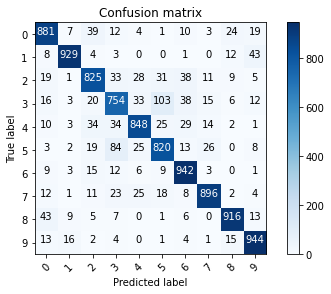

In [29]:
p_test_CNN_improved,y_test,x_test = predict_model(model_CNN_improved,test_loader_improved,test_dataset,device,model_mode="CNN",mode=1)

cm_CNN_improved = confusion_matrix(y_test,p_test_CNN_improved)
plot_confusion_matrix(cm_CNN_improved, list(range(K)))

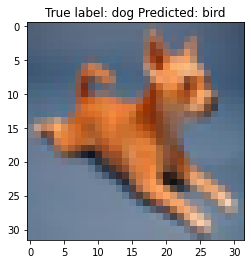

In [30]:
p_test_CNN_improved = p_test_CNN_improved.astype(np.uint8)
misclassified_idx_improved = np.where(p_test_CNN_improved!=y_test)[0]
i = np.random.choice(misclassified_idx_improved)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (cifar_labels[y_test[i]], cifar_labels[int(p_test_CNN_improved[i])]));

In [37]:
# model summary
summary(model_CNN_improved, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,248
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
         MaxPool2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
              ReLU-9           [-1, 64, 16, 16]               0
      BatchNorm2d-10           [-1, 64, 16, 16]             128
           Conv2d-11           [-1, 64, 16, 16]          36,928
             ReLU-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
        MaxPool2d-14             [-1, 6

### 3.Linear

In [ ]:
model_Linear, train_losses_Linear, test_losses_Linear, device ,train_loader, test_loader = create_model_and_train(K,train_dataset,test_dataset,model_mode="Linear",batch_size=128,n_epochs=50)

cuda:0
Epoch 1/50, Train Loss: 2.2084, Test Loss: 2.0674, Duration: 0:01:17.407026
Epoch 2/50, Train Loss: 2.0488, Test Loss: 2.0280, Duration: 0:01:17.675020
Epoch 3/50, Train Loss: 2.0171, Test Loss: 2.0029, Duration: 0:01:18.264376
Epoch 4/50, Train Loss: 1.9841, Test Loss: 1.9550, Duration: 0:01:18.283609
Epoch 5/50, Train Loss: 1.9261, Test Loss: 1.8470, Duration: 0:01:18.223253
Epoch 6/50, Train Loss: 1.8204, Test Loss: 1.7551, Duration: 0:01:18.255776
Epoch 7/50, Train Loss: 1.7631, Test Loss: 1.7828, Duration: 0:01:18.202528
Epoch 8/50, Train Loss: 1.7190, Test Loss: 1.6876, Duration: 0:01:18.183608
Epoch 9/50, Train Loss: 1.6672, Test Loss: 1.6613, Duration: 0:01:18.202539
Epoch 10/50, Train Loss: 1.6226, Test Loss: 1.6328, Duration: 0:01:18.155600
Epoch 11/50, Train Loss: 1.5902, Test Loss: 1.5960, Duration: 0:01:18.125588
Epoch 12/50, Train Loss: 1.5590, Test Loss: 1.5470, Duration: 0:01:18.057715
Epoch 13/50, Train Loss: 1.5254, Test Loss: 1.5481, Duration: 0:01:18.094305
E

#### Evaluate model and plot results

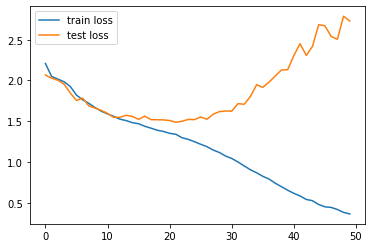

In [ ]:
plot_test_and_train_metric(train_losses_Linear, test_losses_Linear,"loss")

In [ ]:
train_acc_Linear = acc_compouter(model_Linear,device,train_loader,model_mode="Linear")
print(f"train acc: {train_acc_Linear}")

test_acc_Linear = acc_compouter(model_Linear,device,test_loader,model_mode="Linear")
print(f"test acc: {test_acc_Linear}")

train acc: 0.89906
test acc: 0.4467


Confusion matrix, without normalization
[[551  51  59  33  57  17  22  24 138  48]
 [ 72 540  24  30  25  18  34  27 107 123]
 [ 78  22 337  88 163  78 101  91  24  18]
 [ 27  22  95 293  89 178 113  93  47  43]
 [ 62   9 173  66 356  36 114 139  26  19]
 [ 29  23  94 201  75 314  79 109  36  40]
 [ 22  21 106 130 147  54 439  45  13  23]
 [ 53  27  64  64  88  63  30 538  23  50]
 [ 98  61  19  32  28  13  25  20 642  62]
 [ 63 213  12  46  19  21  26  48  95 457]]


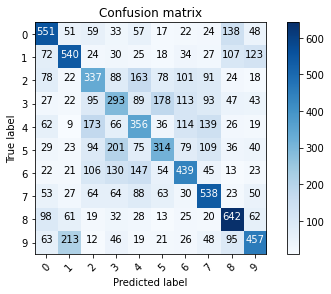

In [ ]:
p_test_Linear,y_test,x_test = predict_model(model_Linear,test_loader,test_dataset,device,model_mode="Linear",mode=1)

cm_Linear = confusion_matrix(y_test,p_test_Linear)
plot_confusion_matrix(cm_Linear, list(range(K)))

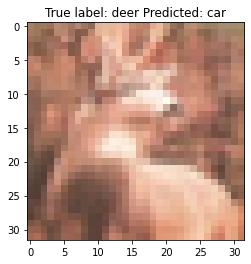

In [ ]:
p_test_Linear = p_test_Linear.astype(np.uint8)
misclassified_idx = np.where(p_test_Linear!=y_test)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (cifar_labels[y_test[i]], cifar_labels[int(p_test_Linear[i])]));